In [10]:
import json
import numpy as np
import pandas as pd

# from array import array
from numpy import float32, array
from itertools import compress
from types import SimpleNamespace   
from collections import defaultdict
import tqdm
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
epoch_data = []
for epoch in range(50):
    with open(f'training_dynamics/lfn/epoch_{epoch}.jsonl', 'r') as json_file:
        json_list = list(json_file)    
    trainings = []
    for i, json_str in enumerate(json_list):
            trainings.append(eval(json_str))
    df = pd.DataFrame.from_records(trainings)
    epoch_data.append(df)

# split the probs into two
for i in range(len(epoch_data)):
    arr = np.array(epoch_data[i]['probs'].loc[:].to_list())
    epoch_data[i]['obj_1_prob'] = arr[:,0]
    epoch_data[i]['obj_2_prob'] = arr[:,1]
    epoch_data[i].drop(columns='probs', inplace=True)


In [3]:
epoch_data[35]

,annotation,obj_0,obj_1,labels,is_visual,obj_1_prob,obj_2_prob
0,wooden chair with cushions,5fe6b79e75130974e8f8c11a24c52ebb,e1c777b80d4e306ef1783a44a88d6274,"[0, 1]",True,0.090843,0.909157
1,wooden slatted chair,e1c777b80d4e306ef1783a44a88d6274,5fe6b79e75130974e8f8c11a24c52ebb,"[1, 0]",False,0.948056,0.051944
2,white and brown chair,5fe6b79e75130974e8f8c11a24c52ebb,e1c777b80d4e306ef1783a44a88d6274,"[0, 1]",True,0.138606,0.861394
3,deep cushioned seat with wooden armrests,e1c777b80d4e306ef1783a44a88d6274,5fe6b79e75130974e8f8c11a24c52ebb,"[1, 0]",False,0.892596,0.107404
4,wood chair with white cushions,5fe6b79e75130974e8f8c11a24c52ebb,e1c777b80d4e306ef1783a44a88d6274,"[0, 1]",True,0.146616,0.853384
...,...,...,...,...,...,...,...
39273,long rectangle on four legs,c28ae120a2d2829e50e9662c8e47fff,746a29a5d7f36b9f14b86d5282eb8301,"[1, 0]",False,0.988569,0.011431
39274,brown dresser,c28ae120a2d2829e50e9662c8e47fff,36bb465e5d81a4e7a0c26936f56da9d2,"[1, 0]",True,0.969700,0.030300
39275,wide dresser with drawers,c28ae120a2d2829e50e9662c8e47fff,ff26f7003826d1a2d810b14a81e12eca,"[1, 0]",False,0.523064,0.476936
39276,dark tea pot,c129a8ee633cc30430e9519d8ae32613,1654250bf1bc5a0131fef20bb2ae787e,"[1, 0]",True,0.987232,0.012768


In [4]:
def compute_forgetfulness(correctness_trend):
    if not any(correctness_trend):  # Example is never predicted correctly, or learnt!
        return 1000
    learnt = False  # Predicted correctly in the current epoch.
    times_forgotten = 0
    for is_correct in correctness_trend:
        if (not learnt and not is_correct) or (learnt and is_correct):
          # nothing changed.
          continue
        elif learnt and not is_correct:
          # Forgot after learning at some point!
            learnt = False
            times_forgotten += 1
        elif not learnt and is_correct:
          # Learnt!
          learnt = True
    return times_forgotten

def compute_train_dy_metrics(training_dynamics, args):
    confidence_ = {}
    variability_ = {}
    threshold_closeness_ = {}
    correctness_ = {}
    forgetfulness_ = {}

    # Functions to be applied to the data.
    variability_func = lambda conf: np.std(conf)
    if args.include_ci:  # Based on prior work on active bias (https://arxiv.org/abs/1704.07433)
        variability_func = lambda conf: np.sqrt(np.var(conf) + np.var(conf) * np.var(conf) / (len(conf)-1))
    threshold_closeness_func = lambda conf: conf * (1 - conf)

    num_tot_epochs = len(list(training_dynamics["probs"][0]))
    print(f"Start offset at {args.start_offset} of {num_tot_epochs}. ")

    if args.burn_out < num_tot_epochs:
        print(f"Computing training dynamics. Burning out at {args.burn_out} of {num_tot_epochs}. ")
    else:
        print(f"Computing training dynamics across {num_tot_epochs} epochs")
        print("Metrics computed: confidence, variability, correctness, forgetfulness, threshold_closeness")
        args.burn_out = num_tot_epochs

    logits = {i: [] for i in range(num_tot_epochs)}
    targets = {i: [] for i in range(num_tot_epochs)}
    training_accuracy = defaultdict(float)

    for guid in tqdm.tqdm(training_dynamics['guid']):
        correctness_trend = []
        true_probs_trend = []
        record = training_dynamics.iloc[guid]
        for i, epoch_logits in enumerate(record["probs"]):
            probs = epoch_logits

            true_class_prob = float(probs[record["gold"]])
            true_probs_trend.append(true_class_prob)

            prediction = np.argmax(epoch_logits)
            is_correct = (prediction == record["gold"]).item()
            correctness_trend.append(is_correct)

            training_accuracy[i] += is_correct
            logits[i].append(epoch_logits)
            targets[i].append(record["gold"])
    
        if args.burn_out < num_tot_epochs or args.start_offset > 0:
            correctness_trend = correctness_trend[args.start_offset:args.burn_out]
            true_probs_trend = true_probs_trend[args.start_offset:args.burn_out]


        correctness_[guid] = np.sum(correctness_trend)
        confidence_[guid] = np.mean(true_probs_trend)
        variability_[guid] = variability_func(true_probs_trend)

        forgetfulness_[guid] = compute_forgetfulness(correctness_trend)
        threshold_closeness_[guid] = threshold_closeness_func(confidence_[guid])

    # Should not affect ranking, so ignoring.
    epsilon_var = np.mean(list(variability_.values()))

    column_names = ['guid',
                  'index',
                  'threshold_closeness',
                  'confidence',
                  'variability',
                  'correctness',
                  'forgetfulness', 
                  'is_visual',
                  'annotation',
                  'obj_0', 'obj_1', 'labels']
    df = pd.DataFrame([[guid,
                      i,
                      threshold_closeness_[guid],
                      confidence_[guid],
                      variability_[guid],
                      correctness_[guid],
                      forgetfulness_[guid],
                      training_dynamics.iloc[guid]['is_visual'],
                      training_dynamics.iloc[guid]['annotation'],
                      training_dynamics.iloc[guid]['obj_0'],
                      training_dynamics.iloc[guid]['obj_1'], 
                      training_dynamics.iloc[guid]['labels'], 

                      ] for i, guid in enumerate(correctness_)], columns=column_names)

    return df


# organize to look nice
probs = np.array([ np.stack([np.array(epoch_df['obj_1_prob']), np.array(epoch_df['obj_2_prob'])]) for epoch_df in epoch_data])

# create a training_dynamics dataframe
td = pd.DataFrame([[guid,
                  probs[:, :, guid],
                  np.argmax(df.iloc[guid]['labels']),
                    df.iloc[guid]['is_visual'],
                    df.iloc[guid]['annotation'],
                    df.iloc[guid]['obj_0'],
                    df.iloc[guid]['obj_1'],
                    df.iloc[guid]['labels']
                  ] for guid, prob in enumerate(probs)], columns=['guid', 'probs', 'gold', 'is_visual', 'annotation', 'obj_0', 'obj_1', 'labels'])



In [5]:
def new_scatter(dataframe, hue_metric ='correct.', title='', model='RoBERTa', show_hist=False, style=None, idxs=None):
    # Subsample data to plot, so the plot is not too busy.
    dataframe = dataframe.sample(n=25000 if dataframe.shape[0] > 25000 else len(dataframe))


    # Normalize correctness to a value between 0 and 1.
    dataframe = dataframe.assign(corr_frac = lambda d: d.correctness / d.correctness.max())
    dataframe['correct.'] = [f"{x:.1f}" for x in dataframe['corr_frac']]

    dataframe = dataframe.sort_values(['correct.'], ascending=True)



    main_metric = 'variability'
    other_metric = 'confidence'

    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
#     style = hue_metric if num_hues < 8 else None
    style=style


    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(16, 8))
        ax0 = axs
    else:
        fig = plt.figure(figsize=(16, 10), )
        gs = fig.add_gridspec(2, 6, height_ratios=[5, 1])

        ax0 = fig.add_subplot(gs[0, :])


    ### Make the scatterplot.

    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

    plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=dataframe,
                           hue=hue,
                           palette=pal,
                           style=style,
                           s=30)

    # Annotate Regions.
    bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    an1 = ax0.annotate("ambiguous", xy=(0.9, 0.5), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", rotation=350, bbox=bb('black'))
    an2 = ax0.annotate("easy-to-learn", xy=(0.27, 0.85), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('r'))
    an3 = ax0.annotate("hard-to-learn", xy=(0.35, 0.25), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('b'))

    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=(1.01, 0.5), loc='center left', fancybox=True, shadow=True)
    else:
        plot.legend(fancybox=True, shadow=True,  ncol=1)

    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')


    if show_hist:
        plot.set_title(f"{model}-{title} Data Map", fontsize=17)

        # Make the histograms.
        ax1 = fig.add_subplot(gs[1, 0])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[1, 2])
        ax4 = fig.add_subplot(gs[1, 3])
        ax5 = fig.add_subplot(gs[1, 4])
        ax6 = fig.add_subplot(gs[1, 5])

        plott0 =  dataframe[dataframe['is_visual']==True].hist(column=['confidence'], ax=ax1, color='#622a87')
        plott0[0].set_title('visual')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')
        
        plott0 =  dataframe[dataframe['is_visual']==False].hist(column=['confidence'], ax=ax2, color='#622a87')
        plott0[0].set_title('blind')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')


        plott1 =  dataframe[dataframe['is_visual']==True].hist(column=['variability'], ax=ax3, color='teal')
        plott1[0].set_title('visual')
        plott1[0].set_xlabel('variability')
        
        plott1 =  dataframe[dataframe['is_visual']==False].hist(column=['variability'], ax=ax4, color='teal')
        plott1[0].set_title('blind')
        plott1[0].set_xlabel('variability')

        plot2 = sns.countplot(x="correct.", data= dataframe[dataframe['is_visual']==True], color='#86bf91', ax=ax5)
        ax5.xaxis.grid(True) # Show the vertical gridlines
        plot2.set_title('visual')
        plot2.set_xlabel('correctness')
        plot2.set_ylabel('')
        
        
        plot2 = sns.countplot(x="correct.", data= dataframe[dataframe['is_visual']==False], color='#86bf91', ax=ax6)
        ax6.xaxis.grid(True) # Show the vertical gridlines
        plot2.set_title('blind')
        plot2.set_xlabel('correctness')
        plot2.set_ylabel('')

    fig.tight_layout()


Start offset at 0 of 50. 
Computing training dynamics. Burning out at 35 of 50. 


100%|██████████| 50/50 [00:00<00:00, 531.33it/s]


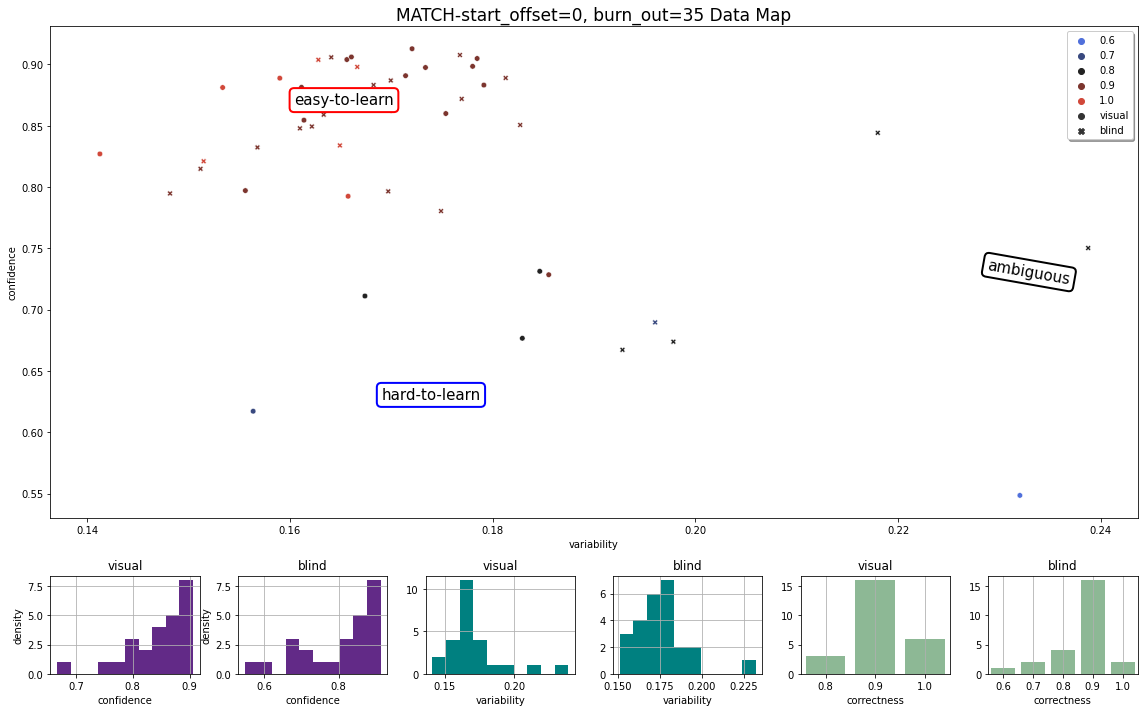

In [11]:
args = {'burn_out':35, 'include_ci':False, 'start_offset':0}
args = SimpleNamespace(**args)
# print(td.iloc[0])
out_df = compute_train_dy_metrics(td, args)
visual_idxs = [int(array) for array in df['is_visual']]
v_markers = ['visual' if int(array) else 'blind' for array in out_df['is_visual']]

new_scatter(out_df, style=v_markers, show_hist=True, title=f'start_offset={args.start_offset}, burn_out={args.burn_out}', model='MATCH')

In [12]:
out_df.head()

,guid,index,threshold_closeness,confidence,variability,correctness,forgetfulness,is_visual,annotation,obj_0,obj_1,labels
0,0,0,0.104692,0.881193,0.153364,35,0,True,wooden chair with cushions,5fe6b79e75130974e8f8c11a24c52ebb,e1c777b80d4e306ef1783a44a88d6274,"[0, 1]"
1,1,1,0.146934,0.821038,0.151488,34,1,False,wooden slatted chair,e1c777b80d4e306ef1783a44a88d6274,5fe6b79e75130974e8f8c11a24c52ebb,"[1, 0]"
2,2,2,0.222030,0.667242,0.192814,28,3,True,white and brown chair,5fe6b79e75130974e8f8c11a24c52ebb,e1c777b80d4e306ef1783a44a88d6274,"[0, 1]"
3,3,3,0.196503,0.731294,0.184651,29,3,False,deep cushioned seat with wooden armrests,e1c777b80d4e306ef1783a44a88d6274,5fe6b79e75130974e8f8c11a24c52ebb,"[1, 0]"
4,4,4,0.187366,0.750268,0.238764,29,1,True,wood chair with white cushions,5fe6b79e75130974e8f8c11a24c52ebb,e1c777b80d4e306ef1783a44a88d6274,"[0, 1]"


In [15]:
from sklearn.neighbors import NearestNeighbors


SCREENSHOT_PATH='data/screenshots'

def visualize_sample(df, point, k=1):
    # visualizes the k-nearest points
    point = np.array(point).reshape(1,-1)
    xys = np.stack([np.array(df['confidence']), np.array(df['variability'])], axis=1)
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(xys)
    distances, indices = nbrs.kneighbors(point)
    indices = indices.squeeze()
    
    for idx in indices:
        # we render each one here
        item = df.iloc[idx]
        path = os.path.join(SCREENSHOT_PATH, item['obj_0'], item['obj_0']+'-6.png')
        img1 = plt.imread(path)
        
        path = os.path.join(SCREENSHOT_PATH, item['obj_1'], item['obj_1']+'-6.png')
        img2 = plt.imread(path) 
        
        
        f, axarr = plt.subplots(1,2)
        f.patch.set_facecolor('white')
        axarr[0].imshow(img1)
        
        axarr[1].imshow(img2)
        
        correct_idx = np.argmax(item['labels'])
        axarr[correct_idx].set_title('confidence:{:.2f}\nvariability:{:.2f}'.format(item['confidence'], item['variability']))

        f.suptitle(item['annotation'])
        print()

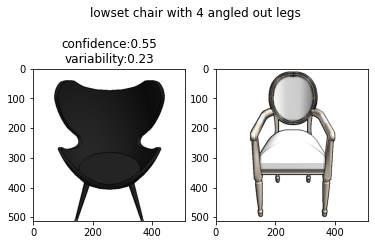

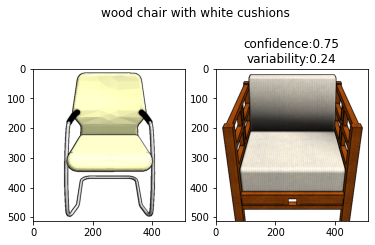

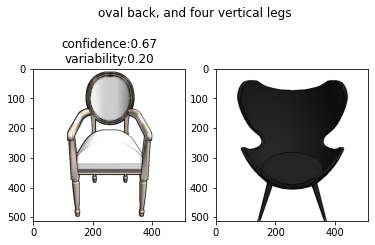

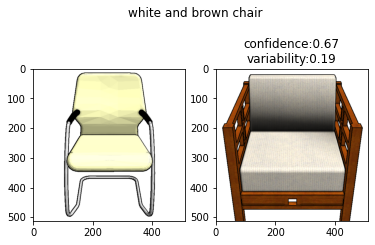

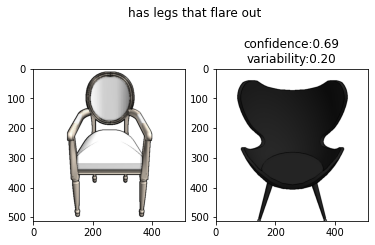

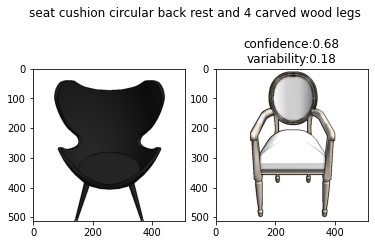

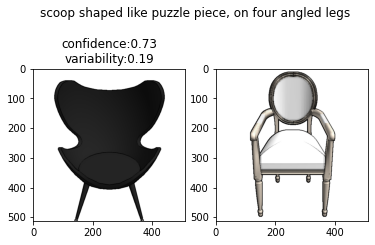

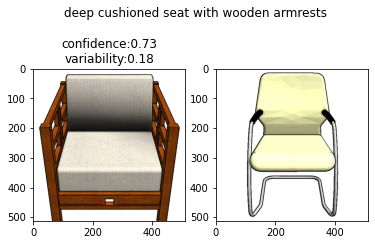

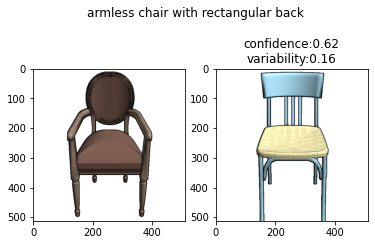

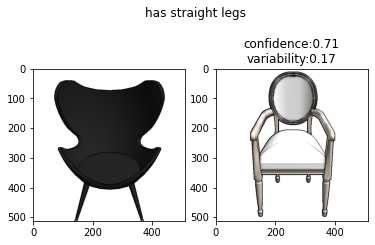

In [16]:
# This should visualize k=10 of the "ambiguious" category
visualize_sample(out_df, (.5, 0.9), k=10)

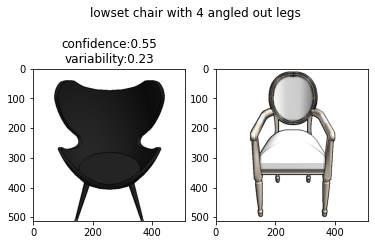

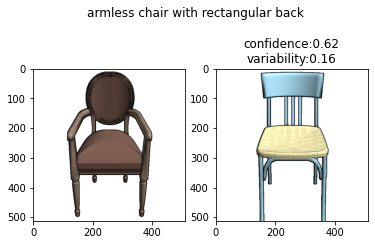

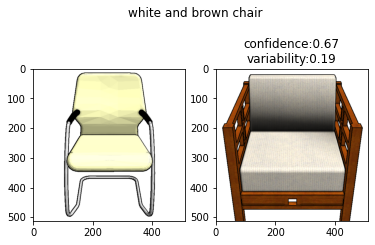

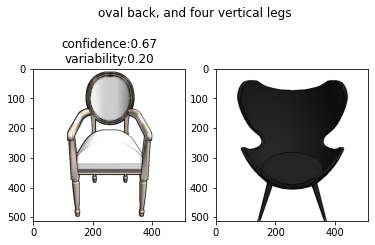

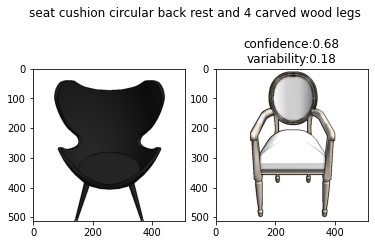

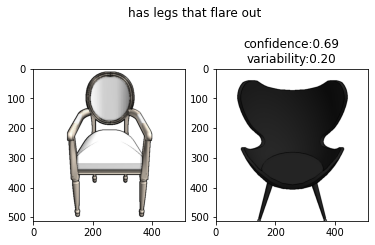

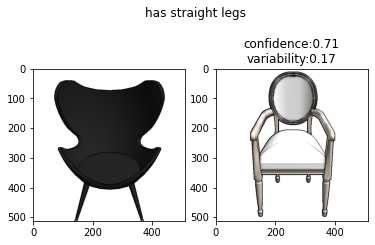

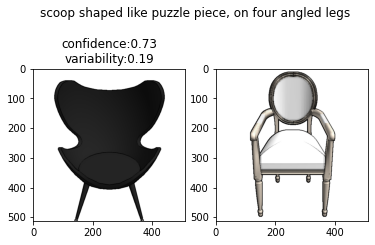

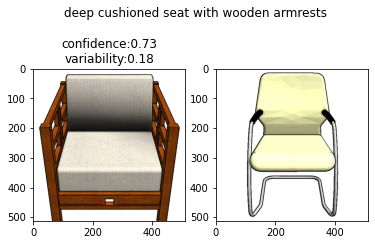

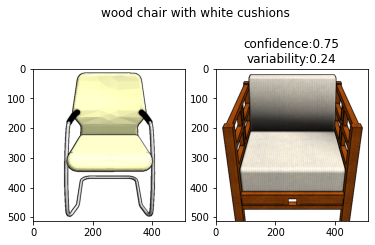

In [17]:
# This should visualize k=10 of the "hard-to-learn" category
visualize_sample(out_df, (0.25, 0.35), k=10)